In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import os

{'closed': 0, 'equal': 1, 'open': 2}


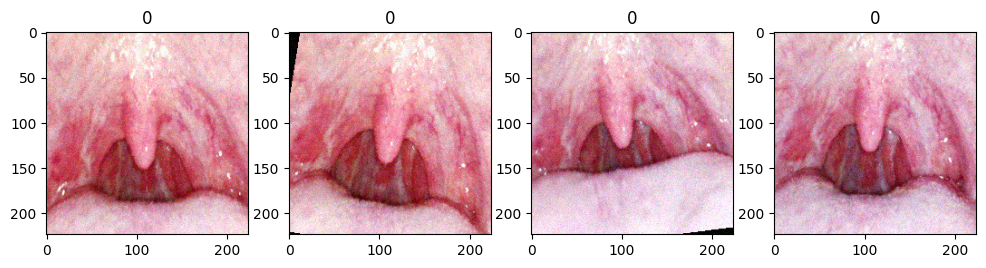

In [2]:
data_dir = '../data/'
train_dir = data_dir + 'images/train/'
valid_dir = data_dir + 'images/valid/'

class AddRandomNoise(v2.Transform):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        noise = torch.randn(img.size()) * self.std + self.mean
        return img + noise

    def __repr__(self):
        return f'{self.__class__.__name__}(mean={self.mean}, std={self.std})'


transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomRotation(10),
    v2.RandomCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    AddRandomNoise(mean=0.0, std=0.05),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = ImageFolder(train_dir, transform=transform, target_transform=None)
valid_set = ImageFolder(valid_dir, transform=transform, target_transform=None)

print(train_set.class_to_idx)

fig, ax = plt.subplots(figsize=(12,8), ncols=4)
for i in range(4):
    image, label = train_set[i]

    # change dimensions to matplotlib order, denormalize and clip RGB values to [0,1]
    rgb_img = (image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    
    ax[i].imshow(rgb_img)
    ax[i].set_title(label)

In [3]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(valid_loader)

def plot_losses(train_losses, valid_losses):
    plt.cla()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    display(plt.gcf())
    clear_output(wait=True)

def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()

    train_losses = []
    valid_losses = []
    best_loss = np.inf

    for epoch in range(num_epochs):
        avg_train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(avg_train_loss)

        avg_val_loss = validate(model, valid_loader, criterion, device)
        valid_losses.append(avg_val_loss)

        print(f'Epoch: {epoch+1}/{num_epochs}.. Training loss: {avg_train_loss:.4f}.. Validation Loss: {avg_val_loss:.4f}')
        plot_losses(train_losses, valid_losses)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            model_name = f'ResNet18_pretrained-epoch{epoch}-batch_size{train_loader.batch_size}-lr{optimizer.param_groups[0]["lr"]}-loss{best_loss:.4f}.pt'
            torch.save(model, '../models/checkpoint.pt')

    # rename model to include hyperparameters
    os.rename('../models/checkpoint.pt', '../models/' + model_name)

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='ResNet18_Weights.IMAGENET1K_V1')

Using cache found in C:\Users\timfa/.cache\torch\hub\pytorch_vision_v0.10.0


In [5]:
batch_size = 32
learning_rate = 0.001
num_epochs = 300

for param in model.parameters():
    param.requires_grad = False

num_classes = len(train_set.class_to_idx)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)

Device: cuda


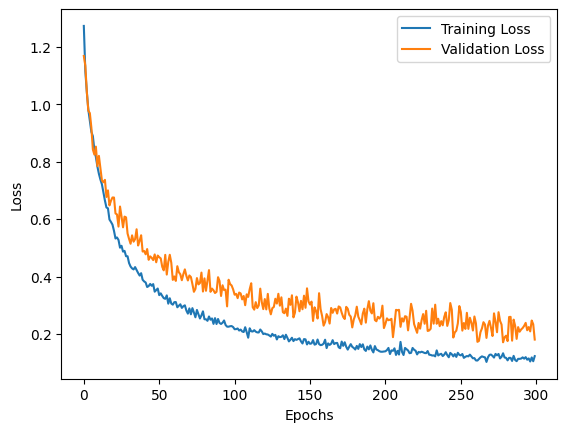

In [6]:
train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device)

In [7]:
### data sample of size one to test the code ###

# import torch.utils.data as data_utils

# num_epochs = 5
# indices = torch.arange(1)

# train_set2 = data_utils.Subset(train_set, indices)
# val_set2 = data_utils.Subset(val_set, indices)

# train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
# val_loader2 = DataLoader(val_set2, batch_size=batch_size, shuffle=False)

# train(model, train_loader2, val_loader2, criterion, optimizer, num_epochs)